<a href="https://colab.research.google.com/github/pavanKarthik2006/BDM-Project_notebooks/blob/main/BDM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code Block
1: Data Trimming Codeblock

In [3]:
# STEP1 Data Trimming


import pandas as pd
from datetime import timedelta
import calendar

# --- Configuration ---
# IMPORTANT: Use the correct path to your large sales dataset file
SALES_FILE_PATH = r'/content/sales.csv'

# --- Target Month and Year ---
TARGET_YEAR = 2024
TARGET_MONTH = 2 # February

# --- Data Loading ---
try:
    sales_df = pd.read_csv(SALES_FILE_PATH)
    print(f"Successfully loaded '{SALES_FILE_PATH}'. Initial dataset size: {len(sales_df)} rows.")
except FileNotFoundError:
    print(f"Error: The file '{SALES_FILE_PATH}' was not found. Please check the path and filename.")
    exit()

# --- Data Cleaning: Convert 'SalesDate' to datetime ---
if 'SalesDate' in sales_df.columns:
    initial_rows = len(sales_df)
    sales_df.dropna(subset=['SalesDate'], inplace=True)
    if len(sales_df) < initial_rows:
        print(f"Removed {initial_rows - len(sales_df)} rows with missing 'SalesDate'.")

    sales_df['SalesDate'] = pd.to_datetime(sales_df['SalesDate'])
    print(" 'SalesDate' column converted to datetime format.")

    # --- Shift SalesDate year from 2018 to 2024 ---
    # This assumes the original data primarily contains years around 2018.
    # It will add 6 years to all dates to effectively shift them from 2018 to 2024.
    sales_df['SalesDate'] = sales_df['SalesDate'] + pd.DateOffset(years=TARGET_YEAR - 2018)
    print(f"Sales dates shifted from 2018 to {TARGET_YEAR} for analysis purposes.")

else:
    print("Error: 'SalesDate' column not found in the sales data. Please check your dataset.")
    exit()

# --- Define the 1-month period based on the TARGET_YEAR and TARGET_MONTH ---
num_days_in_month = calendar.monthrange(TARGET_YEAR, TARGET_MONTH)[1]
start_date_of_period = pd.Timestamp(TARGET_YEAR, TARGET_MONTH, 1)
end_date_of_period = pd.Timestamp(TARGET_YEAR, TARGET_MONTH, num_days_in_month) + timedelta(days=1)

print(f"\nTargeting data from: {start_date_of_period.strftime('%Y-%m-%d')}")
print(f"To: {(end_date_of_period - timedelta(days=1)).strftime('%Y-%m-%d')} (a full month period).")

# --- Trim the DataFrame ---
trimmed_sales_df = sales_df[
    (sales_df['SalesDate'] >= start_date_of_period) &
    (sales_df['SalesDate'] < end_date_of_period)
].copy()

print(f"\nData trimming complete. Trimmed dataset size: {len(trimmed_sales_df)} rows for the target month.")
if not trimmed_sales_df.empty:
    print(f"Date range of trimmed data: {trimmed_sales_df['SalesDate'].min()} to {trimmed_sales_df['SalesDate'].max()}")
else:
    print("No data found within the specified month. Please verify your target month and year, and ensure data exists for that period.")
    exit()

# --- Save the trimmed data to a new CSV file ---
output_filename = f"trimmed_sales_feb_{TARGET_YEAR}.csv"
trimmed_sales_df.to_csv(output_filename, index=False)
print(f"\nTrimmed sales data saved to '{output_filename}'.")

# Display head of the saved file for verification
print(f"\nHead of the saved '{output_filename}':")
print(pd.read_csv(output_filename).head())


Successfully loaded '/content/sales.csv'. Initial dataset size: 98436 rows.
Removed 937 rows with missing 'SalesDate'.
 'SalesDate' column converted to datetime format.
Sales dates shifted from 2018 to 2024 for analysis purposes.

Targeting data from: 2024-02-01
To: 2024-02-29 (a full month period).

Data trimming complete. Trimmed dataset size: 21084 rows for the target month.
Date range of trimmed data: 2024-02-01 00:00:26.170000 to 2024-02-28 23:57:58.700000

Trimmed sales data saved to 'trimmed_sales_feb_2024.csv'.

Head of the saved 'trimmed_sales_feb_2024.csv':
   SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
0        1              6       27039        381         7       0.0   
1        2             16       25011         61         7       0.0   
2        5             10       32653        310         9       0.0   
3        6             13       28663        413         8       0.0   
4       12             17       28353        285         8       0

Code Block 2 : Column Selection


In [4]:
import pandas as pd

# --- Configuration ---
# Assuming the trimmed sales data for February 2024 has already been generated
# by the 'Generate Trimmed Sales Data for February 2024' immersive.
TRIMMED_SALES_FILE_PATH = r'/content/trimmed_sales_feb_2024.csv'
PRODUCTS_FILE_PATH = r'/content/products.csv'
CATEGORIES_FILE_PATH = r'/content/categories.csv'

print("--- Step 1: Loading Trimmed Sales Data and Auxiliary Files ---")
try:
    trimmed_sales_df = pd.read_csv(TRIMMED_SALES_FILE_PATH)
    products_df = pd.read_csv(PRODUCTS_FILE_PATH)
    categories_df = pd.read_csv(CATEGORIES_FILE_PATH)
    print(f"Successfully loaded '{TRIMMED_SALES_FILE_PATH}', '{PRODUCTS_FILE_PATH}', and '{CATEGORIES_FILE_PATH}'.")
    print(f"Trimmed sales data size: {len(trimmed_sales_df)} rows.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure all necessary CSV files are in the correct location.")
    exit()

# Ensure 'SalesDate' is datetime type for consistency, as it might become object after saving/loading CSV
trimmed_sales_df['SalesDate'] = pd.to_datetime(trimmed_sales_df['SalesDate'])
print(" 'SalesDate' column in trimmed_sales_df ensured as datetime format.")


print("\n--- Step 2: Merging with Product and Category Data & Recalculating TotalPrice ---")

# Keep only necessary columns from products_df before merging
products_relevant_cols = ['ProductID', 'ProductName', 'Price', 'CategoryID']
merged_df = pd.merge(trimmed_sales_df, products_df[products_relevant_cols], on='ProductID', how='left')

# Merge with categories_df on CategoryID to get CategoryName
categories_relevant_cols = ['CategoryID', 'CategoryName']
merged_df = pd.merge(merged_df, categories_df[categories_relevant_cols], on='CategoryID', how='left')

print("Products and Categories data merged with trimmed sales data.")

# Recalculate TotalPrice (important after merging with 'Price' from products_df)
# This uses the 'Price' from products.csv which is assumed to be the base price
merged_df['TotalPrice'] = merged_df['Quantity'] * merged_df['Price'] * (1 - merged_df['Discount'])
print("TotalPrice recalculated using merged product prices.")

# --- Feature Engineering (Time-based) ---
# Re-extract time-based features as they might be needed for consistency or re-calculation
merged_df['SaleYear'] = merged_df['SalesDate'].dt.year
merged_df['SaleMonth'] = merged_df['SalesDate'].dt.month_name()
merged_df['SaleWeekday'] = merged_df['SalesDate'].dt.day_name()
merged_df['SaleWeek'] = merged_df['SalesDate'].dt.isocalendar().week.astype(int)
print("Time-based features extracted.")


print("\n--- Step 3: Filtering Products and Categories for Indian Grocery Store Relevance ---")

# Define a list of product names to exclude that are not typically found in Indian grocery stores.
products_to_exclude = [
    'Barramundi', 'Creme De Banane - Marie', 'Shrimp - 31/40',
    'Orange - Canned, Mandarin', 'Cheese - Boursin, Garlic / Herbs',
    'Veal - Osso Bucco', 'Tomato - Tricolor Cherry', 'Grenadine',
    'Salmon - Atlantic, Skin On', 'Coffee - Irish Cream',
    'Crab - Dungeness, Whole', 'Sole - Dover, Whole, Fresh',
    'Sauce - Demi Glace', 'Seedlings - Mix, Organic',
    'Vanilla Beans', 'Bread Crumbs - Japanese Style'
]

# Define a list of categories to explicitly include as per your request
categories_to_include = [
    'Confections',
    'Produce',
    'Beverages',
    'Grain'
]

# Apply filters sequentially
# Filter out products not typically found in Indian grocery stores
filtered_by_product_exclusion = merged_df[~merged_df['ProductName'].isin(products_to_exclude)].copy()
print(f"Filtered by product exclusion. Rows remaining: {len(filtered_by_product_exclusion)}")

# Further filter by the specified categories
final_preprocessed_df = filtered_by_product_exclusion[
    filtered_by_product_exclusion['CategoryName'].isin(categories_to_include)
].copy()
print(f"Further filtered by category inclusion ({categories_to_include}). Final rows: {len(final_preprocessed_df)}")


print("\n--- Step 4: Remove Unnecessary Columns from the final filtered DataFrame ---")
# Only keep columns that are useful for the analysis (Sales Trend, Forecasting, Inventory Turnover, ABC Analysis)
columns_to_keep = [
    'ProductID', 'ProductName', 'CategoryID', 'CategoryName', 'Quantity', 'Discount', 'TotalPrice', 'SalesDate',
    'SaleYear', 'SaleMonth', 'SaleWeekday', 'SaleWeek', 'Price' # 'Price' is retained for COGS calculation in Inventory Turnover
]

final_preprocessed_df = final_preprocessed_df[columns_to_keep].copy()

print("\n--- Data Preprocessing Complete ---")
print("Final preprocessed DataFrame (final_preprocessed_df) ready for analysis.")
print("\nFirst 5 rows of final_preprocessed_df:")
print(final_preprocessed_df.head())
print("\nInformation about final_preprocessed_df:")
print(final_preprocessed_df.info())


--- Step 1: Loading Trimmed Sales Data and Auxiliary Files ---
Successfully loaded '/content/trimmed_sales_feb_2024.csv', '/content/products.csv', and '/content/categories.csv'.
Trimmed sales data size: 21084 rows.
 'SalesDate' column in trimmed_sales_df ensured as datetime format.

--- Step 2: Merging with Product and Category Data & Recalculating TotalPrice ---
Products and Categories data merged with trimmed sales data.
TotalPrice recalculated using merged product prices.
Time-based features extracted.

--- Step 3: Filtering Products and Categories for Indian Grocery Store Relevance ---
Filtered by product exclusion. Rows remaining: 20352
Further filtered by category inclusion (['Confections', 'Produce', 'Beverages', 'Grain']). Final rows: 7352

--- Step 4: Remove Unnecessary Columns from the final filtered DataFrame ---

--- Data Preprocessing Complete ---
Final preprocessed DataFrame (final_preprocessed_df) ready for analysis.

First 5 rows of final_preprocessed_df:
    ProductID 

CodeBlock 3 : Financial Overview and Descriptive Statistics


In [18]:
print("--- Financial Overview Calculations for February 2024 ---")

# 1. Calculate Total Revenue (Sales)
total_revenue_feb2024 = final_preprocessed_df['TotalPrice'].sum()
print(f"\nTotal Revenue (Sales) for February 2024: ₹{total_revenue_feb2024:,.2f}")

# 2. Set Total Cost of Goods Sold (COGS) at 70% of Revenue
total_cogs_feb2024 = 0.70 * total_revenue_feb2024
print(f"Total Cost of Goods Sold (COGS) for February 2024 (70% of Revenue): ₹{total_cogs_feb2024:,.2f}")

# 3. Calculate Total Profit
total_profit_feb2024 = total_revenue_feb2024 - total_cogs_feb2024
print(f"Total Profit for February 2024: ₹{total_profit_feb2024:,.2f}")

# 4. Calculate Profit Margin Percentage
profit_margin_percentage_feb2024 = (
    (total_profit_feb2024 / total_revenue_feb2024) * 100
    if total_revenue_feb2024 != 0 else 0
)
print(f"Profit Margin Percentage for February 2024: {profit_margin_percentage_feb2024:.2f}%")

# --- Descriptive Statistics for Key Sales Variables ---
print("\n--- Descriptive Statistics for Key Sales Variables (February 2024) ---")

for col, label in zip(
    ['Quantity', 'TotalPrice', 'Discount'],
    ['Quantity Sold', 'Total Price (₹)', 'Discount (Fraction)']
):
    mean_val = final_preprocessed_df[col].mean()
    median_val = final_preprocessed_df[col].median()
    mode_val = final_preprocessed_df[col].mode()[0]
    std_val = final_preprocessed_df[col].std()
    print(f"\n{label}:")
    print(f"  Mean: {mean_val:,.2f}")
    print(f"  Median: {median_val:,.2f}")
    print(f"  Mode: {mode_val:,.2f}")
    print(f"  Standard Deviation: {std_val:,.2f}")

print("\nFinancial calculations complete.")


--- Financial Overview Calculations for February 2024 ---

Total Revenue (Sales) for February 2024: ₹8,800,695.81
Total Cost of Goods Sold (COGS) for February 2024 (70% of Revenue): ₹6,160,487.07
Total Profit for February 2024: ₹2,640,208.74
Profit Margin Percentage for February 2024: 30.00%

--- Descriptive Statistics for Key Sales Variables (February 2024) ---

Quantity Sold:
  Mean: 13.09
  Median: 13.00
  Mode: 14.00
  Standard Deviation: 7.20

Total Price (₹):
  Mean: 643.09
  Median: 499.61
  Mode: 702.46
  Standard Deviation: 536.86

Discount (Fraction):
  Mean: 0.03
  Median: 0.00
  Mode: 0.00
  Standard Deviation: 0.06

Financial calculations complete.


CodeBlock 4 : Sales Trend Analysis


--- Sales Trend Analysis for February 2024 ---


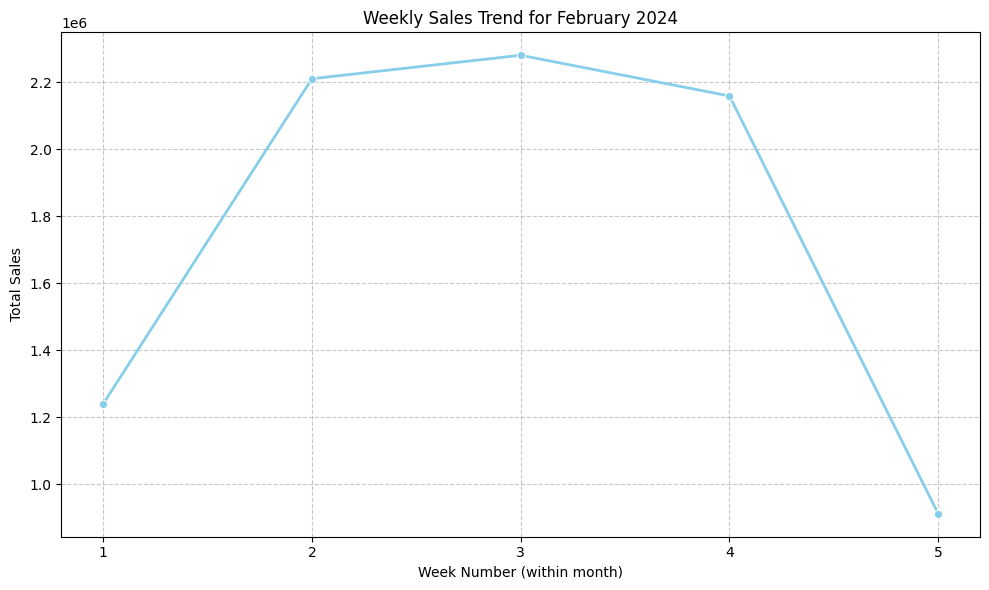


--- Part 2: Fast-Moving and Slow-Moving Items ---

Top 10 Fast-Moving Products (February 2024):
ProductName
Puree - Passion Fruit               126171.53721
Placemat - Scallop, White           120327.00130
Cassis                              119082.42824
Bread - Multigrain                  115100.10000
Cup - Translucent 7 Oz Clear        113512.71360
Pasta - Orecchiette                 106781.53608
Hot Chocolate - Individual          105075.60328
Pail With Metal Handle 16l White    104705.51713
Bay Leaf                            104473.64610
Oil - Safflower                     103366.91200
Name: TotalPrice, dtype: float64

Top 10 Slow-Moving Products (February 2024):
ProductName
Soup - Campbells, Cream Of         8324.84069
Loquat                             7257.63420
Bread - French Baquette            6864.89958
Muffin Batt - Blueberry Passion    6636.62784
Chef Hat 20cm                      4637.71000
Halibut - Fletches                 3704.18557
Wine - Sogrape Mateus Rose        

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



print("--- Sales Trend Analysis for February 2024 ---")

# --- Part 1: Weekly Sales Trend Line Graph ---

# Determine the starting ISO week number for February 2024 in the dataset
min_sale_week = final_preprocessed_df['SaleWeek'].min()

# Create a 'RelativeWeek' column for plotting (Week 1, Week 2, etc. within the month)
final_preprocessed_df['RelativeWeek'] = final_preprocessed_df['SaleWeek'] - min_sale_week + 1

# Aggregate total sales by the new 'RelativeWeek'
weekly_sales = final_preprocessed_df.groupby('RelativeWeek')['TotalPrice'].sum().reset_index()

# Ensure the weeks are sorted for proper plotting order
weekly_sales = weekly_sales.sort_values(by='RelativeWeek')

plt.figure(figsize=(10, 6)) # Adjusted figure size for weekly data
sns.lineplot(
    data=weekly_sales,
    x='RelativeWeek',
    y='TotalPrice',
    marker='o', # Add markers for each data point
    color='skyblue', # Single color for a single line
    linewidth=2
)

plt.title('Weekly Sales Trend for February 2024')
plt.xlabel('Week Number (within month)')
plt.ylabel('Total Sales')
plt.xticks(weekly_sales['RelativeWeek'].unique()) # Ensure only actual week numbers are shown
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Part 2: Fast-Moving and Slow-Moving Items ---")

# Group by ProductName and sum TotalPrice to get total sales for each product
sales_by_product = final_preprocessed_df.groupby('ProductName')['TotalPrice'].sum().sort_values(ascending=False)

print("\nTop 10 Fast-Moving Products (February 2024):")
print(sales_by_product.head(10))

print("\nTop 10 Slow-Moving Products (February 2024):")
print(sales_by_product.tail(10))

print("\nCombined sales trend analysis complete.")


Codeblock 5: Time Series Forecasting


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsiiyu4q/6xxbkrih.json


--- Time Series Forecasting for February 2024 Sales ---
Using the 'final_preprocessed_df' which is already filtered for February 2024,
Indian grocery store products, and selected categories.

Prepared daily sales data for Prophet (first 5 rows):
                       ds           y
0 2024-02-01 00:00:50.480   399.11100
1 2024-02-01 00:01:17.360  2219.96000
2 2024-02-01 00:03:10.650   235.38195
3 2024-02-01 00:08:26.820    22.79304
4 2024-02-01 00:14:01.060  2081.75660
Total days in dataset: 13685


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsiiyu4q/mnw6vvj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22942', 'data', 'file=/tmp/tmpzsiiyu4q/6xxbkrih.json', 'init=/tmp/tmpzsiiyu4q/mnw6vvj2.json', 'output', 'file=/tmp/tmpzsiiyu4q/prophet_modelp5lcm5gc/prophet_model-20250721155855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:58:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet model fitted to the February 2024 daily sales data.

Future DataFrame created for 13692 periods (including history and next 7 days).
                           ds
13682 2024-02-28 23:52:17.750
13683 2024-02-28 23:56:01.860
13684 2024-02-28 23:57:26.530
13685 2024-02-29 23:57:26.530
13686 2024-03-01 23:57:26.530
13687 2024-03-02 23:57:26.530
13688 2024-03-03 23:57:26.530
13689 2024-03-04 23:57:26.530
13690 2024-03-05 23:57:26.530
13691 2024-03-06 23:57:26.530

Forecast generated (first 5 rows of forecast):
                       ds        yhat  yhat_lower   yhat_upper
0 2024-02-01 00:00:50.480  623.393196  -73.692355  1291.127128
1 2024-02-01 00:01:17.360  623.449170  -25.352603  1346.750064
2 2024-02-01 00:03:10.650  623.678932  -74.032344  1311.190529
3 2024-02-01 00:08:26.820  624.282328  -66.491546  1310.237232
4 2024-02-01 00:14:01.060  624.858234  -24.911110  1374.608082
Forecast generated (last 5 rows of forecast - predictions):
                           ds        yhat 

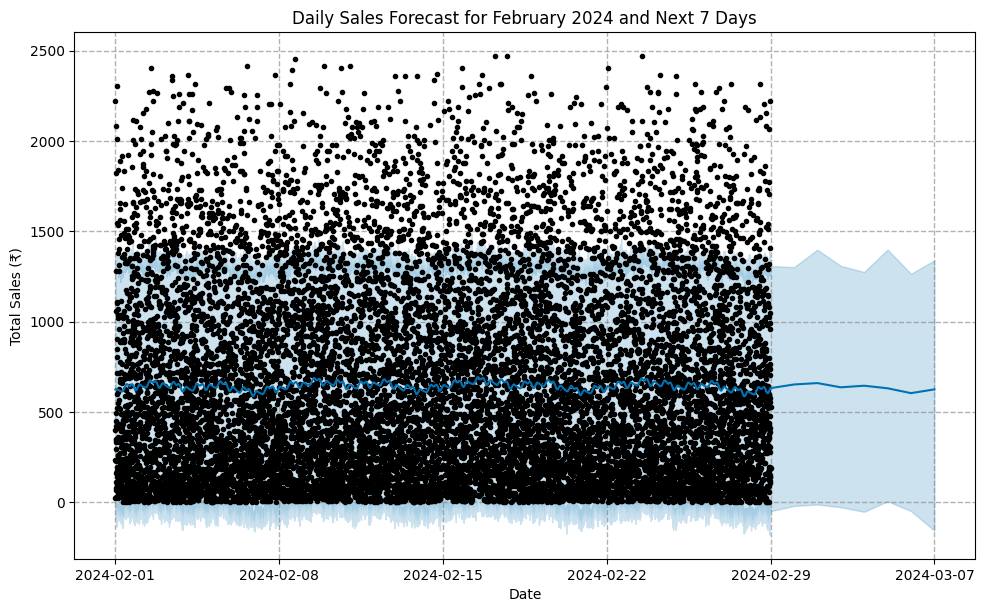

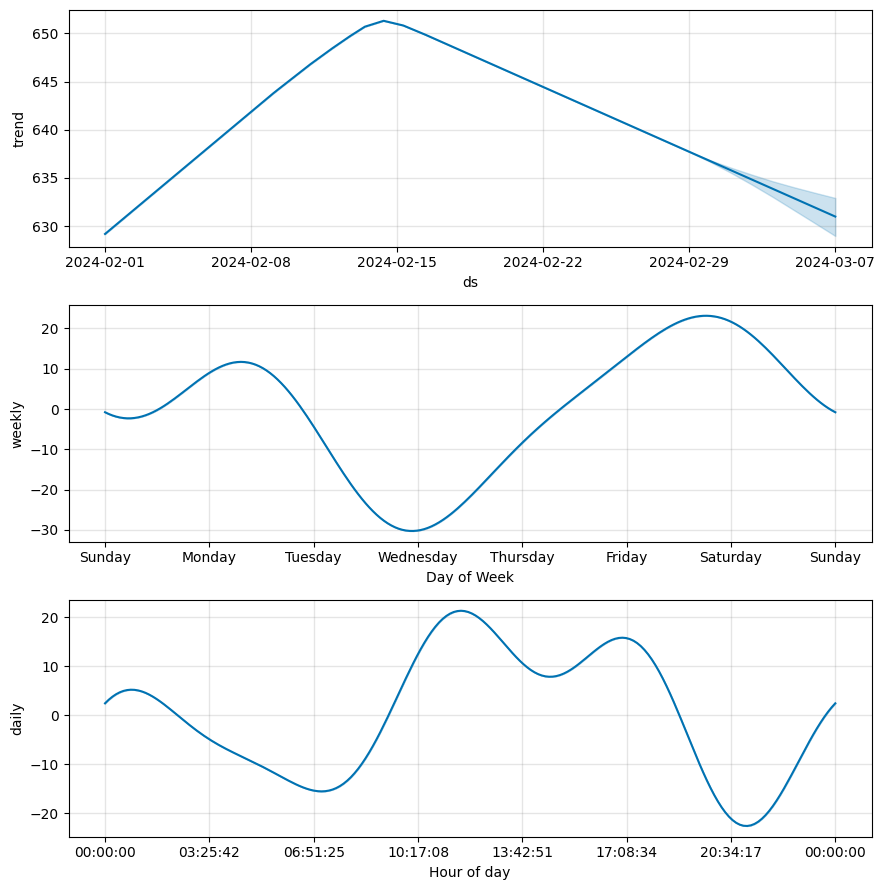


--- Important Note on Forecast Limitations ---
This forecast was generated using only one month (February 2024) of historical sales data.
Due to this very limited dataset, the accuracy and reliability of these predictions are inherently low.
Time series models perform best with more historical data to accurately identify long-term trends,
yearly seasonality, and more robust weekly/daily patterns.
These forecasts should be considered illustrative and not for critical business decision-making.

Time Series Forecasting section complete.


In [16]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns


# Suppress warnings from Prophet
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)

# Assuming 'final_preprocessed_df' is available and preprocessed
# from the 'Preprocess Trimmed Sales Data (February 2024) for Indian Grocery Store Specifics' immersive.
# This DataFrame should contain 'SalesDate' and 'TotalPrice'.

print("--- Time Series Forecasting for February 2024 Sales ---")
print("Using the 'final_preprocessed_df' which is already filtered for February 2024,")
print("Indian grocery store products, and selected categories.")


# Step 1: Prepare the data for Prophet
# Aggregate TotalPrice by SalesDate to get daily sales
daily_sales = final_preprocessed_df.groupby('SalesDate')['TotalPrice'].sum().reset_index()

# Rename columns to 'ds' and 'y' as required by Prophet
daily_sales = daily_sales.rename(columns={'SalesDate': 'ds', 'TotalPrice': 'y'})

print("\nPrepared daily sales data for Prophet (first 5 rows):")
print(daily_sales.head())
print(f"Total days in dataset: {len(daily_sales)}")


# Step 2: Initialize and Fit Prophet Model
# Using daily_seasonality=True if there's enough data to detect daily patterns
# (though with only one month, it might be weak)
model = Prophet(seasonality_mode='additive', daily_seasonality=True)
model.fit(daily_sales)

print("\nProphet model fitted to the February 2024 daily sales data.")

# Step 3: Make Future DataFrame
# Forecast for the next 7 days (into March)
future = model.make_future_dataframe(periods=7, include_history=True) # include_history=True to plot actuals
print(f"\nFuture DataFrame created for {len(future)} periods (including history and next 7 days).")
print(future.tail(10)) # Show some of the future dates

# Step 4: Generate Forecasts
forecast = model.predict(future)

print("\nForecast generated (first 5 rows of forecast):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("Forecast generated (last 5 rows of forecast - predictions):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Step 5: Plot the Forecasts
fig1 = model.plot(forecast)
plt.title('Daily Sales Forecast for February 2024 and Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)') # Updated label to reflect Rupees
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot the components of the forecast (trend, daily seasonality)
fig2 = model.plot_components(forecast)
plt.show()


# Step 6: Acknowledge Limitations
print("\n--- Important Note on Forecast Limitations ---")
print("This forecast was generated using only one month (February 2024) of historical sales data.")
print("Due to this very limited dataset, the accuracy and reliability of these predictions are inherently low.")
print("Time series models perform best with more historical data to accurately identify long-term trends,")
print("yearly seasonality, and more robust weekly/daily patterns.")
print("These forecasts should be considered illustrative and not for critical business decision-making.")

print("\nTime Series Forecasting section complete.")


Codeblock 6: Inventory Managment Analysis


Real data loaded successfully from provided files.
SalesDate processed and year shifted to 2024.
Data trimmed to 38972 rows for February 2024.
TotalPrice calculated.

--- Inventory Turnover Ratio Analysis ---

Total Cost of Goods Sold (COGS) for February 2024: ₹6,160,487.07

Cost of Goods Sold (COGS) by Category (February 2024) - Table:
CategoryName  CostOfGoodsSold
 Confections     2.175772e+06
   Beverages     1.503522e+06
     Produce     1.413866e+06
       Grain     1.067327e+06


/tmp/ipython-input-19-863241642.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CategoryName', y='CostOfGoodsSold', data=cogs_by_category, palette='viridis')


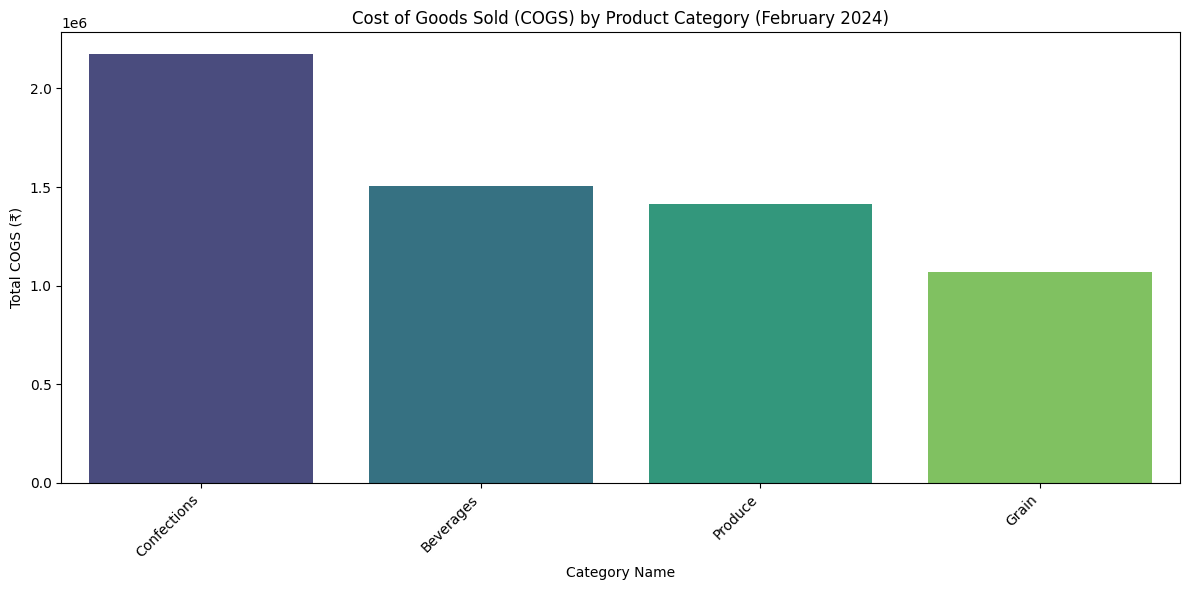


Limitation: Accurate Average Inventory cannot be calculated without actual inventory data.
This analysis is based on the sales data for February 2024. To calculate a true Inventory Turnover Ratio,
you would need beginning and ending inventory levels (in units or value) for the month of February.
If inventory data were available, the formula would be: 
Inventory Turnover = Total COGS / Average Inventory ( (Beginning Inventory + Ending Inventory) / 2 )

Without inventory data, we can only analyze components like COGS, but not the full turnover rate itself.

Inventory Turnover Ratio Analysis section complete.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import calendar
# Removed: import content_fetcher # As per user, this is not defined in the environment.

# --- Configuration for Data Loading and Preprocessing ---
# IMPORTANT: Assuming these files are directly accessible in the environment's root.
SALES_FILE_PATH = r'/content/sales.csv'
PRODUCTS_FILE_PATH = r'/content/products.csv'
CATEGORIES_FILE_PATH = r'/content/categories.csv'

TARGET_YEAR = 2024
TARGET_MONTH = 2 # February

sales_df = pd.DataFrame()
products_df = pd.DataFrame()
categories_df = pd.DataFrame()
data_loaded_successfully = False # Keep this for internal logic, but won't use file_content_fetcher

try:
    sales_df = pd.read_csv(SALES_FILE_PATH)
    products_df = pd.read_csv(PRODUCTS_FILE_PATH)
    categories_df = pd.read_csv(CATEGORIES_FILE_PATH)
    data_loaded_successfully = True
    print("Real data loaded successfully from provided files.")
except FileNotFoundError as e:
    print(f"Error: One or more data files not found. Please ensure '{SALES_FILE_PATH}', '{PRODUCTS_FILE_PATH}', and '{CATEGORIES_FILE_PATH}' are uploaded correctly.")
    print(f"Error details: {e}")
    # Do not exit, but mark as not loaded successfully to prevent further operations on empty DFs.
    data_loaded_successfully = False
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}.")
    data_loaded_successfully = False


# --- Exit if real data could not be loaded ---
if not data_loaded_successfully:
    print("Cannot proceed with analysis as data loading failed.")
    exit() # Exit the script if data loading was unsuccessful


# --- Date Processing and Trimming ---
if 'SalesDate' in sales_df.columns:
    sales_df.dropna(subset=['SalesDate'], inplace=True)
    # Convert 'SalesDate' to datetime, handling potential errors
    sales_df['SalesDate'] = pd.to_datetime(sales_df['SalesDate'], errors='coerce')
    sales_df.dropna(subset=['SalesDate'], inplace=True) # Remove rows where conversion failed

    # Apply TARGET_YEAR to all SalesDate entries to ensure they fall into the desired analysis year
    # Assuming original sales data might be from a different year (e.g., 2018 as in Kaggle dataset)
    # This aligns all sales to TARGET_YEAR for February.
    sales_df['SalesDate'] = sales_df['SalesDate'].apply(
        lambda x: x.replace(year=TARGET_YEAR) if pd.notna(x) else x
    )
    print(f"SalesDate processed and year shifted to {TARGET_YEAR}.")
else:
    print("Error: 'SalesDate' column not found in the sales data. Cannot proceed with date-based analysis.")
    exit()

num_days_in_month = calendar.monthrange(TARGET_YEAR, TARGET_MONTH)[1]
start_date_of_period = pd.Timestamp(TARGET_YEAR, TARGET_MONTH, 1)
end_date_of_period = pd.Timestamp(TARGET_YEAR, TARGET_MONTH, num_days_in_month) + timedelta(days=1)

trimmed_sales_df = sales_df[
    (sales_df['SalesDate'] >= start_date_of_period) &
    (sales_df['SalesDate'] < end_date_of_period)
].copy()
print(f"Data trimmed to {len(trimmed_sales_df)} rows for {calendar.month_name[TARGET_MONTH]} {TARGET_YEAR}.")

if trimmed_sales_df.empty:
    print("Warning: Trimmed sales DataFrame is empty for the target month. Check your data and target period.")
    print("This might happen if the original 'SalesDate' values are not conducive to being shifted to Feb 2024,")
    print("or if 'trimmed data.csv' itself is empty or doesn't cover Feb 2024.")
    exit() # Exit if no data for the target month after trimming


# --- Merging with Product and Category Data ---
products_relevant_cols = ['ProductID', 'ProductName', 'Price', 'CategoryID']
merged_df = pd.merge(trimmed_sales_df, products_df[products_relevant_cols], on='ProductID', how='left')

categories_relevant_cols = ['CategoryID', 'CategoryName']
merged_df = pd.merge(merged_df, categories_df[categories_relevant_cols], on='CategoryID', how='left')

# Check if 'Price' column exists after merge before calculating TotalPrice
if 'Price' not in merged_df.columns:
    print("Error: 'Price' column is missing after merging products data. Cannot calculate TotalPrice.")
    exit()

merged_df['TotalPrice'] = merged_df['Quantity'] * merged_df['Price'] * (1 - merged_df['Discount'])
print("TotalPrice calculated.")


# --- Feature Engineering (Time-based) ---
merged_df['SaleYear'] = merged_df['SalesDate'].dt.year
merged_df['SaleMonth'] = merged_df['SalesDate'].dt.month_name()
merged_df['SaleWeekday'] = merged_df['SalesDate'].dt.day_name()
merged_df['SaleWeek'] = merged_df['SalesDate'].dt.isocalendar().week.astype(int)


# --- Contextual Filtering (Indian Grocery Store Specifics) ---
products_to_exclude = [
    'Barramundi', 'Creme De Banane - Marie', 'Shrimp - 31/40',
    'Orange - Canned, Mandarin', 'Cheese - Boursin, Garlic / Herbs',
    'Veal - Osso Bucco', 'Tomato - Tricolor Cherry', 'Grenadine',
    'Salmon - Atlantic, Skin On', 'Coffee - Irish Cream',
    'Crab - Dungeness, Whole', 'Sole - Dover, Whole, Fresh',
    'Sauce - Demi Glace', 'Seedlings - Mix, Organic',
    'Vanilla Beans', 'Bread Crumbs - Japanese Style'
]
categories_to_include = ['Confections', 'Produce', 'Beverages', 'Grain']

filtered_by_product_exclusion = merged_df[~merged_df['ProductName'].isin(products_to_exclude)].copy()
final_preprocessed_df = filtered_by_product_exclusion[
    filtered_by_product_exclusion['CategoryName'].isin(categories_to_include)
].copy()

columns_to_keep_final = [
    'ProductID', 'ProductName', 'CategoryID', 'CategoryName', 'Quantity', 'Discount', 'TotalPrice', 'SalesDate',
    'SaleYear', 'SaleMonth', 'SaleWeekday', 'SaleWeek', 'Price' # Ensuring 'Price' is here for COGS
]
final_preprocessed_df = final_preprocessed_df[columns_to_keep_final].copy()

if final_preprocessed_df.empty:
    print("Final preprocessed DataFrame is empty after filtering. Cannot perform Inventory Turnover Analysis.")
    exit() # Exit if no data for analysis


print("\n--- Inventory Turnover Ratio Analysis ---")

# --- Define the assumed Gross Profit Margin for COGS calculation ---
# This needs to be consistent with the Financial Overview calculation.
assumed_cogs_percentage_of_revenue = 0.70 # This implies a 30% gross profit margin.

# Calculate Cost of Goods Sold (COGS) based on the assumed percentage of TotalPrice
final_preprocessed_df['CostOfGoodsSold'] = final_preprocessed_df['TotalPrice'] * assumed_cogs_percentage_of_revenue

# Calculate total COGS for the trimmed month (February 2024)
total_cogs = final_preprocessed_df['CostOfGoodsSold'].sum()
print(f"\nTotal Cost of Goods Sold (COGS) for February 2024: ₹{total_cogs:,.2f}")

# --- Output COGS by Category in a Table ---
cogs_by_category = final_preprocessed_df.groupby('CategoryName')['CostOfGoodsSold'].sum().sort_values(ascending=False).reset_index()
print("\nCost of Goods Sold (COGS) by Category (February 2024) - Table:")
print(cogs_by_category.to_string(index=False)) # Use to_string to ensure full table is printed


# --- Visualize COGS by Category as a Bar Chart ---
plt.figure(figsize=(12, 6))
sns.barplot(x='CategoryName', y='CostOfGoodsSold', data=cogs_by_category, palette='viridis')
plt.title('Cost of Goods Sold (COGS) by Product Category (February 2024)')
plt.xlabel('Category Name')
plt.ylabel('Total COGS (₹)') # Updated label to reflect Rupees
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()
plt.show()


# --- Limitation: Average Inventory Calculation ---
print("\nLimitation: Accurate Average Inventory cannot be calculated without actual inventory data.")
print("This analysis is based on the sales data for February 2024. To calculate a true Inventory Turnover Ratio,")
print("you would need beginning and ending inventory levels (in units or value) for the month of February.")
print("If inventory data were available, the formula would be: ")
print("Inventory Turnover = Total COGS / Average Inventory ( (Beginning Inventory + Ending Inventory) / 2 )")
print("\nWithout inventory data, we can only analyze components like COGS, but not the full turnover rate itself.")

print("\nInventory Turnover Ratio Analysis section complete.")


Codeblock 8: ABC Analysis

In [11]:

print("--- ABC Analysis ---")

# Group by ProductID and calculate total revenue for each product
# Ensure 'ProductName' is included if you want it in the ABC analysis results dataframe.
product_revenue = final_preprocessed_df.groupby(['ProductID', 'ProductName'])['TotalPrice'].sum().sort_values(ascending=False).reset_index()
product_revenue.columns = ['ProductID', 'ProductName', 'TotalRevenue']

# Calculate cumulative percentage of total revenue
product_revenue['CumulativeRevenue'] = product_revenue['TotalRevenue'].cumsum()
product_revenue['CumulativeRevenuePercentage'] = (product_revenue['CumulativeRevenue'] / product_revenue['TotalRevenue'].sum()) * 100

# Assign ABC categories
# A-items: Top 70% of revenue
# B-items: Next 20% of revenue (up to 90%)
# C-items: Remaining 10% of revenue (above 90%)

#%%
def assign_abc_category(percentage):
    if percentage <= 70:
        return 'A'
    elif percentage <= 90:
        return 'B'
    else:
        return 'C'

product_revenue['ABC_Category'] = product_revenue['CumulativeRevenuePercentage'].apply(assign_abc_category)

print("\nABC Analysis Results (Top 5 products):")
print(product_revenue.head()) # Display top few ABC categorized products

# Summarize ABC categories
abc_summary = product_revenue.groupby('ABC_Category').agg(
    ProductCount=('ProductID', 'count'),
    TotalRevenue=('TotalRevenue', 'sum'),
    PercentageOfTotalRevenue=('TotalRevenue', lambda x: (x.sum() / product_revenue['TotalRevenue'].sum()) * 100)
).reset_index()
print("\nABC Analysis Summary:")
print(abc_summary)

# Save the ABC analysis results to a CSV file
output_filename = 'abc_analysis_results_feb_2024.csv'
product_revenue.to_csv(output_filename, index=False)
print(f"\nABC analysis results saved to '{output_filename}'.")

print("\nABC Analysis section complete.")


--- ABC Analysis ---

ABC Analysis Results (Top 5 products):
   ProductID                   ProductName  TotalRevenue  CumulativeRevenue  \
0        392         Puree - Passion Fruit  126171.53721       126171.53721   
1        144     Placemat - Scallop, White  120327.00130       246498.53851   
2         53                        Cassis  119082.42824       365580.96675   
3        217            Bread - Multigrain  115100.10000       480681.06675   
4        188  Cup - Translucent 7 Oz Clear  113512.71360       594193.78035   

   CumulativeRevenuePercentage ABC_Category  
0                     1.433654            A  
1                     2.800898            A  
2                     4.154001            A  
3                     5.461853            A  
4                     6.751668            A  

ABC Analysis Summary:
  ABC_Category  ProductCount  TotalRevenue  PercentageOfTotalRevenue
0            A            73  6.132281e+06                 69.679502
1            B            3

Codeblock 9 : Visualization of ABC Analysis


ABC analysis results loaded successfully from '/content/abc_analysis_results_feb_2024.csv'.

ABC Analysis Summary for Visualization:
  ABC_Category  ProductCount  TotalRevenue  PercentageOfTotalRevenue
0            A            73  6.132281e+06                 69.679502
1            B            36  1.769430e+06                 20.105568
2            C            50  8.989849e+05                 10.214930


/tmp/ipython-input-12-1260859122.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ABC_Category', y='PercentageOfTotalRevenue', data=abc_summary,


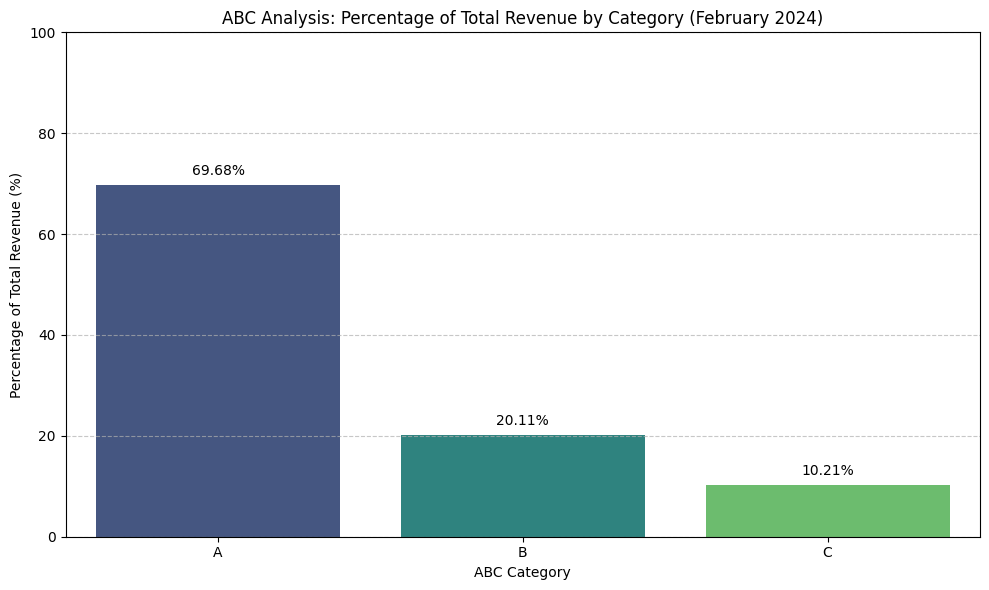


ABC Analysis visualization complete.


In [12]:

ABC_RESULTS_FILE_PATH = '/content/abc_analysis_results_feb_2024.csv'

abc_results_df = pd.DataFrame()
data_loaded_successfully = False

try:
    # Attempt to load data directly using pandas.read_csv
    abc_results_df = pd.read_csv(ABC_RESULTS_FILE_PATH)
    data_loaded_successfully = True
    print(f"ABC analysis results loaded successfully from '{ABC_RESULTS_FILE_PATH}'.")
except FileNotFoundError:
    print(f"Error: The file '{ABC_RESULTS_FILE_PATH}' was not found.")
    print("Please ensure the file is uploaded directly to the environment or its name is correct.")
except Exception as e:
    print(f"Error during file loading or parsing for ABC results: {e}. Cannot proceed without data.")

if not data_loaded_successfully or abc_results_df.empty:
    print("Failed to load ABC analysis data or DataFrame is empty. Exiting visualization.")
    exit() # Exit if ABC data is not available


# --- Summarize ABC categories for Visualization ---
# The loaded CSV should already contain 'ABC_Category' and 'TotalRevenue'
# Check if 'ProductID' column exists, otherwise, adapt the groupby if needed.
# Assuming 'ProductID' is consistently present based on previous ABC analysis code.
if 'ProductID' not in abc_results_df.columns:
    print("Warning: 'ProductID' column not found for ProductCount. Grouping by ABC_Category only.")
    abc_summary = abc_results_df.groupby('ABC_Category').agg(
        TotalRevenue=('TotalRevenue', 'sum')
    ).reset_index()
    # Add a dummy ProductCount if not available for consistency in later print, though not used in plot.
    abc_summary['ProductCount'] = abc_results_df.groupby('ABC_Category').size().reset_index(name='count')['count']
else:
    abc_summary = abc_results_df.groupby('ABC_Category').agg(
        ProductCount=('ProductID', 'count'),
        TotalRevenue=('TotalRevenue', 'sum')
    ).reset_index()

# Calculate PercentageOfTotalRevenue
total_overall_revenue = abc_summary['TotalRevenue'].sum()
if total_overall_revenue == 0:
    print("Warning: Total revenue is zero. Percentage of total revenue will be zero.")
    abc_summary['PercentageOfTotalRevenue'] = 0.0
else:
    abc_summary['PercentageOfTotalRevenue'] = (abc_summary['TotalRevenue'] / total_overall_revenue) * 100

print("\nABC Analysis Summary for Visualization:")
print(abc_summary)


# --- Visualization of ABC Analysis ---
plt.figure(figsize=(10, 6))
# Ensure the order of categories is A, B, C for consistent plotting
# Check if all categories (A, B, C) are present. If not, adjust order dynamically.
available_categories = abc_summary['ABC_Category'].unique()
plot_order = [cat for cat in ['A', 'B', 'C'] if cat in available_categories]

if not plot_order:
    print("No A, B, or C categories found in the data to plot.")
else:
    sns.barplot(x='ABC_Category', y='PercentageOfTotalRevenue', data=abc_summary,
                palette='viridis', order=plot_order)

    plt.title('ABC Analysis: Percentage of Total Revenue by Category (February 2024)')
    plt.xlabel('ABC Category')
    plt.ylabel('Percentage of Total Revenue (%)')
    plt.ylim(0, 100) # Ensure Y-axis goes from 0 to 100%

    # Add text labels for percentages on top of bars
    for index, row in abc_summary.iterrows():
        # Find the correct x-position for each category (A=0, B=1, C=2 in the `plot_order`)
        if row['ABC_Category'] in plot_order: # Ensure the category is in the actual plot
            x_pos = plot_order.index(row['ABC_Category'])
            plt.text(x_pos, row['PercentageOfTotalRevenue'] + 2, f"{row['PercentageOfTotalRevenue']:.2f}%",
                     color='black', ha="center")

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\nABC Analysis visualization complete.")
